# LS11 with Tunable Periodic Components (HadCRUT4-gl Version)

Loehle and Scafetta (2011) (hereafter LS11) propose a model for global mean surface temperatures (GMST) where the natural component is composed of a linear term and two cyclic terms, with periods of 20 and 60 years, to which a linear term is added (from approximately 1942 onwards) representing anthropogenic influences:

\begin{equation*}
   y(t) = A \cos\left[2\pi(t - T_1)/H \right] + B \cos\left[2\pi(t - T_2)/G \right] + C(t-1900) + D + \max\left[E + F\times(t-1950), 0\right].
\end{equation*}

The parameters of this model, taken from LS11 are as follows:

\begin{equation*}
   A = 0.121,~~
   B = 0.041,~~
   C = 0.0016,~~
   D = -0.317,~~
   E = 0.054,~~
   F = 0.0066,~~
   G = 20, ~~
   H = 60, ~~
   T_1 = 1998.58,~~
   T_2 = 1999.65.
\end{equation*}

In this notebook, we will also tune the periodicities of the sinusoidal components. This time we use HadCRUT4-gl to get a better idea of how the predictions are shaping up.

First we import libraries for maths functions etc., plotting and downloading data:

In [1]:
import numpy as np;
import matplotlib.pyplot as plt
import urllib.request
from scipy.optimize import least_squares 

Next, we download the HadCRUT3-gl dataset from CRU webserver and extract the data, which are on alternate lines of the file.  The year is in the first column and the annual global mean surface temperature anomaly is in the last column.  

In [2]:
response = urllib.request.urlopen('https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT4-gl.dat')
year, temp = [], [];
for count, line in enumerate(response, start=1):
    if count % 2 == 1:
        line = line.split();
        year.append(int(line[0]))
        temp.append(float(line[-1]))

We then define a function that implements the LS11 model.  This time, rather than the parameters being hard-coded as in the previous notebook, they are provided as an argument.  The arguments expected to be numpy array objects.

In [3]:
def ls11(year, theta) : 
    return (  theta[3] 
            + theta[2]*(year - 1900) 
            + theta[1]*np.cos(2*np.pi*(year - theta[9])/theta[6]) 
            + theta[0]*np.cos(2*np.pi*(year - theta[8])/theta[7]) 
            + np.maximum(theta[4] + theta[5]*(year-1950), 0))

Just as a sanity check, reproduce the graph uwing an array of model parameters as given by LS11:

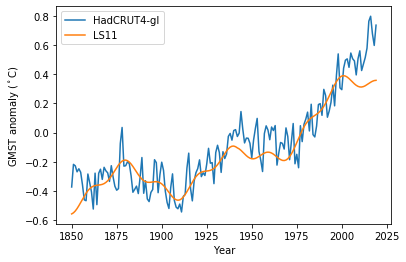

In [4]:
theta = np.array([0.121, 0.041, 0.0016, -0.317, 0.054, 0.0066, 20, 60, 1998.58, 1999.65]);
year  = np.array(year);
temp  = np.array(temp);
pred  = ls11(year, theta);
plt.plot(year, temp, year, pred);
plt.ylabel('GMST anomaly ($^\circ$C)');
plt.xlabel('Year');
plt.legend(['HadCRUT4-gl', 'LS11']);

Attempt to fit the natural component of the model via non-linear least-squares optimisation, using the same calibration period (1850-1950)

In [5]:
def ls11natural(year, theta) : 
    return (  theta[3] 
            + theta[2]*(year - 1900) 
            + theta[1]*np.cos(2*np.pi*(year - theta[9])/theta[6]) 
            + theta[0]*np.cos(2*np.pi*(year - theta[8])/theta[7]))

def fun(theta, year, temp):
    return ls11natural(year, theta) - temp

idx    = year <= 1950;
result = least_squares(fun, theta.copy(), loss='linear', args=(year[idx], temp[idx]));
phi    = result.x;

Plot the natural component:

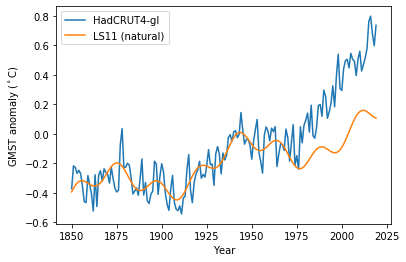

In [6]:
pred  = ls11natural(year, result.x);
plt.plot(year, temp, year, pred);
plt.ylabel('GMST anomaly ($^\circ$C)');
plt.xlabel('Year');
plt.legend(['HadCRUT4-gl', 'LS11 (natural)']);

Fit the anthropogenic component of the model to the residuals for 1950-2010.  Note that with tunable periodicities for the cyclic components, the residuals from 1950 can once more be reasonably modelled as a linear function. 

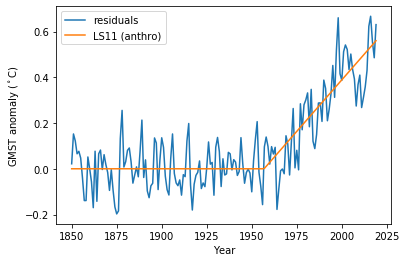

In [7]:
idx = (year >= 1950) & (year <= 2010);
X = np.array([np.ones(year[idx].shape), year[idx]-1950]).T;
y = temp[idx] - pred[idx];
phi[4:6] = (np.linalg.pinv(X.T@X)@(X.T@y));
plt.plot(year, temp-pred, year, np.maximum(phi[5]*(year-1950) + phi[4], 0));
plt.ylabel('GMST anomaly ($^\circ$C)');
plt.xlabel('Year');
plt.legend(['residuals', 'LS11 (anthro)']);

Lastly plot the natural and anthropogenic components

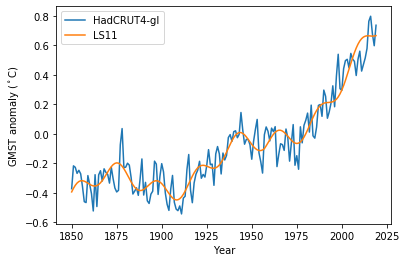

In [8]:
pred  = ls11(year, phi);
plt.plot(year, temp, year, pred);
plt.ylabel('GMST anomaly ($^\circ$C)');
plt.xlabel('Year');
plt.legend(['HadCRUT4-gl', 'LS11']);

If the periodicities are made tunable, instead of being 20 and 60 years, they are approximately 22 years and 76 years (obviously very different to LS11!).  The slope of the anthropogenic component has also rise from 0.066 to 0.0090, a substantial increase.

In [9]:
phi

array([ 1.17818580e-01,  6.36949878e-02,  2.84845441e-03, -2.93479512e-01,
       -6.14874555e-02,  9.00473685e-03,  2.23748301e+01,  7.63406786e+01,
        2.02172870e+03,  2.00974377e+03])

## References:

[LS11] Craig Loehle and Nicola Scafetta, "Climate Change Attribution Using Empirical Decomposition of Climate Data", <i>The Open Atmospheric Science Journal</i>, volume 5, pages 74-86, 2011.